In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dataset = pd.read_csv('../EDA/numData.csv')
Y = pd.read_csv('../EDA/y.csv')

In [4]:
dataset = dataset.merge(Y, how='left', on=["country","year"])

In [6]:
X_without = dataset.drop(columns=["year","country"], axis=0)

In [15]:
bigMissing = X_without.isna().sum()[(X_without.isna().sum() / X_without.shape[0]) > 0.8].keys()
X_without = X_without.drop(columns=bigMissing, axis=0)

In [16]:
X_without = X_without.replace(np.inf, 0)
X_without = X_without.replace(-np.inf, 0)
X_without = X_without.fillna(0)

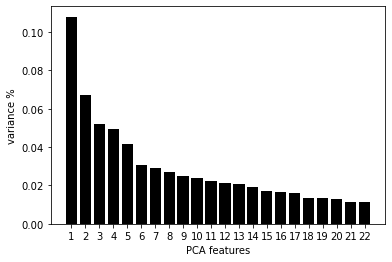

<Figure size 1440x144 with 0 Axes>

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = StandardScaler().fit_transform(X_without)

pca = PCA()
principalComponents = pca.fit_transform(X)

features = range(1,23)
plt.bar(features, pca.explained_variance_ratio_[:22], color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.figure(figsize=(20, 2))

PCA_components = pd.DataFrame(principalComponents)

In [18]:
np.sum(pca.explained_variance_ratio_[:8])

0.404916590507609

In [14]:
from sklearn.manifold import TSNE
tSNE = TSNE(n_components=3)
tSNE_COMPS = tSNE.fit_transform(PCA_components)

tSNE_PCA_components = pd.DataFrame(tSNE_COMPS)

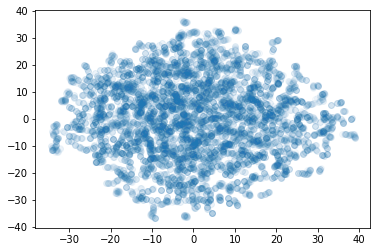

In [15]:
plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[1], alpha=.04)
plt.show()

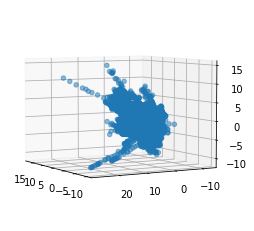

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(PCA_components[0], PCA_components[2], PCA_components[3], alpha=.5)
ax.view_init(elev=5., azim=150)

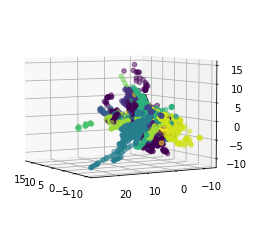

In [20]:
from sklearn import mixture
from mpl_toolkits.mplot3d import Axes3D

components = 15
features = 11

gmm = mixture.GaussianMixture(n_components=components, covariance_type='full')
labels = gmm.fit_predict(PCA_components.iloc[:,:features])

X_without["gmmLabels-"+str(components)+str(features)] = labels
dataset["gmmLabels-"+str(components)+str(features)] = labels

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(PCA_components[0], PCA_components[1], PCA_components[3], c=labels, alpha=.5)
ax.view_init(elev=5., azim=150)

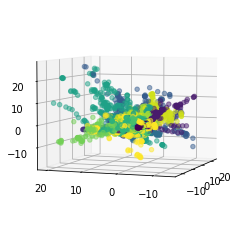

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(PCA_components[0], PCA_components[2], PCA_components[4], c=labels, alpha=.5)
ax.view_init(elev=5., azim=200)

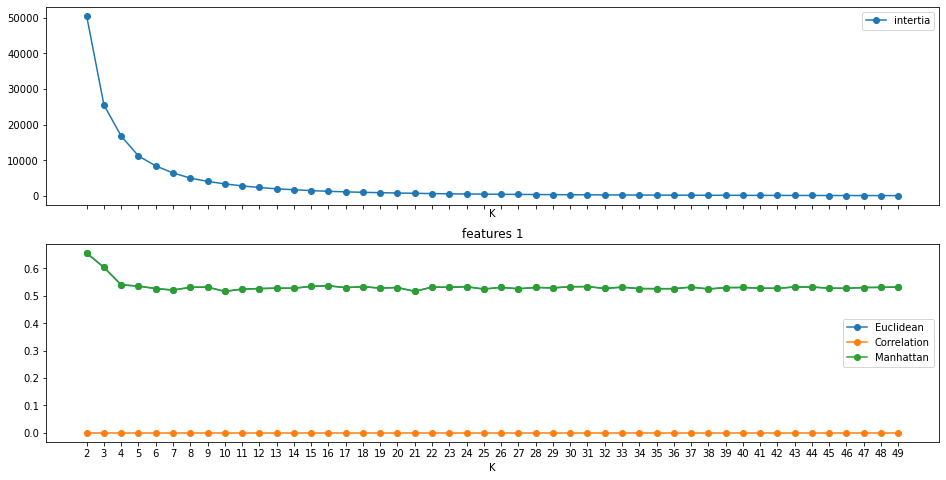

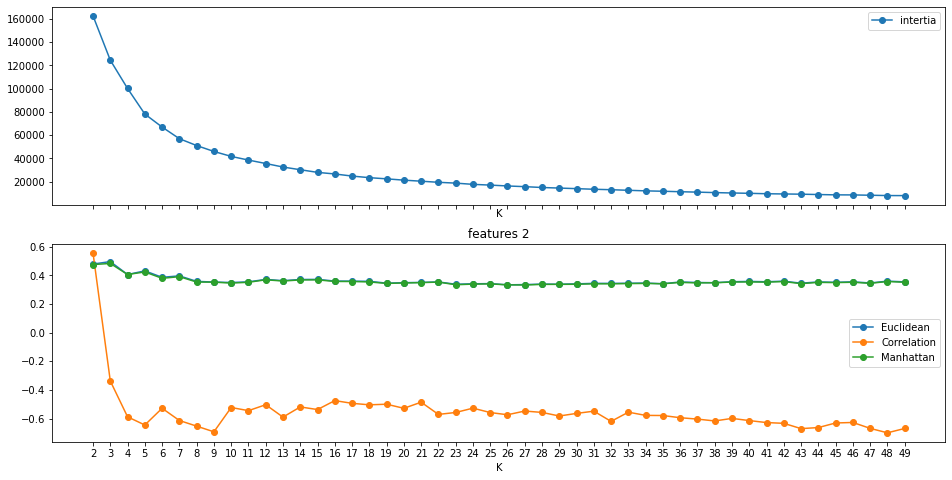

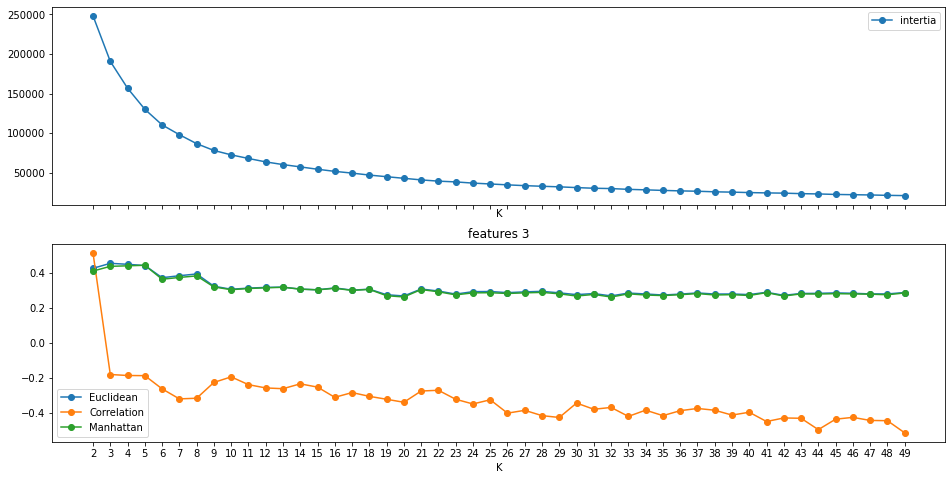

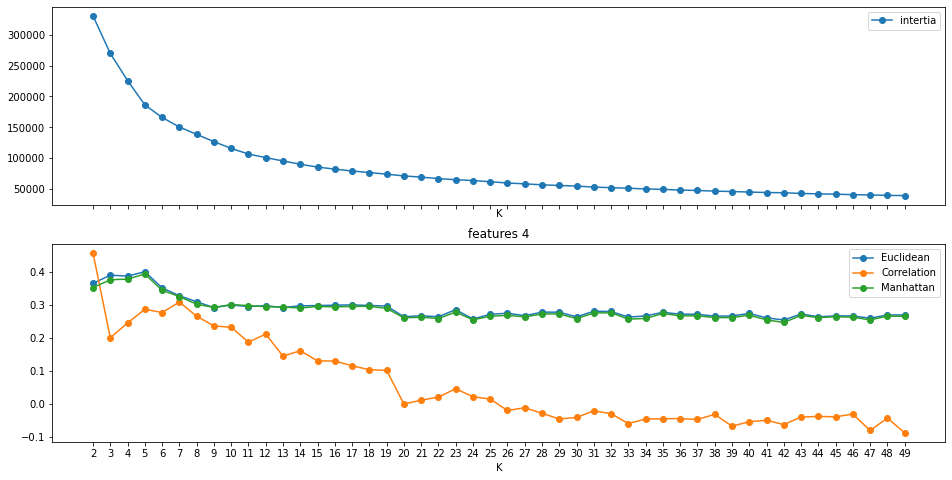

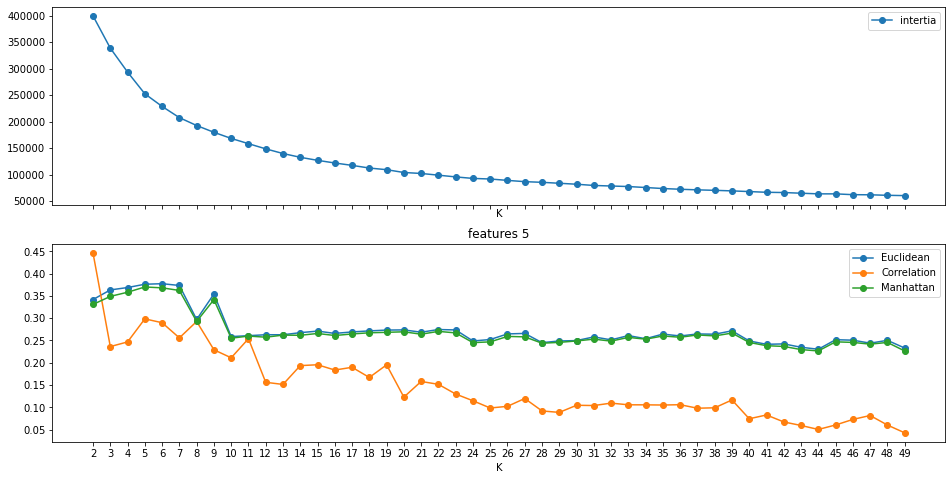

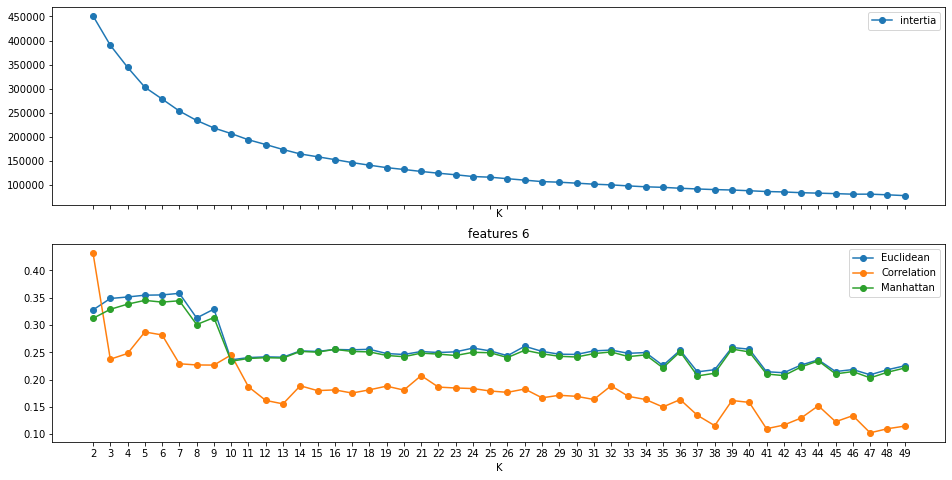

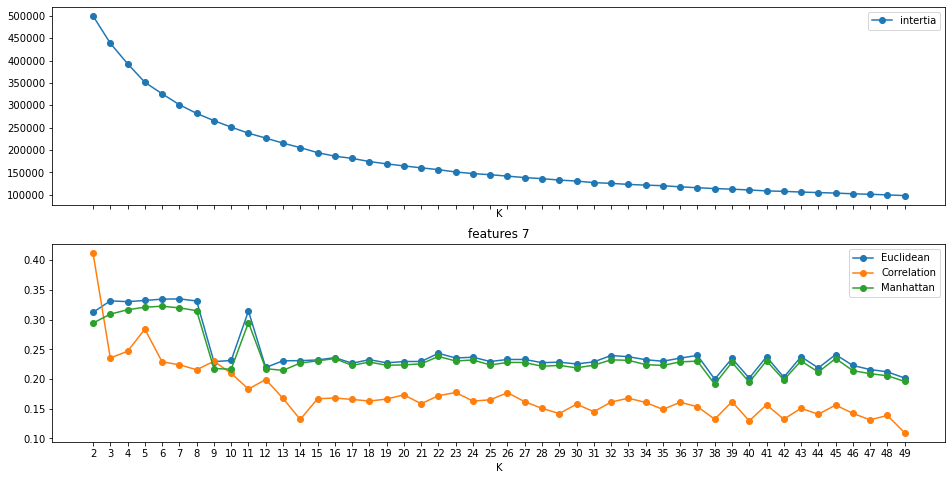

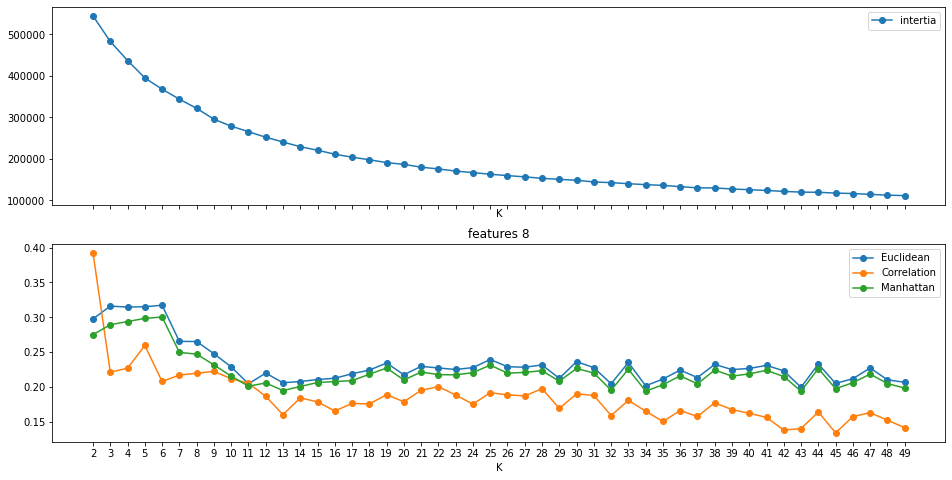

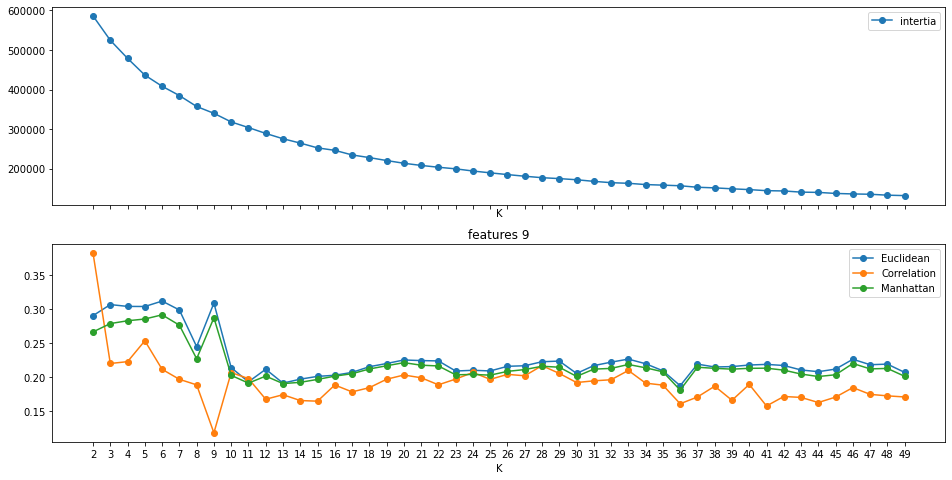

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.metrics import  silhouette_score

k_cand = list(np.arange(2,50,1))

results = dict()

for features in range(1,10):
    for k in k_cand:

        kmeans = KMeans( n_clusters=k)
        labels = kmeans.fit_predict(PCA_components.iloc[:,:features])
        score0 = kmeans.inertia_
        score1 = silhouette_score(PCA_components.iloc[:,:features],labels,metric='euclidean')
        score2 = silhouette_score(PCA_components.iloc[:,:features],labels,metric='correlation')
        score3 = silhouette_score(PCA_components.iloc[:,:features],labels,metric='manhattan')
        results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2,'s3':score3}

    fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
    plt.title('features '+ str(features))
    axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='intertia')
    axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
    axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
    axs[1].plot([i for i in results.keys()],[i['s3'] for i in results.values()],'o-',label='Manhattan')
    for ax in axs:
        ax.set_xticks(k_cand)
        ax.set_xlabel('K')
        ax.legend()

    plt.show()

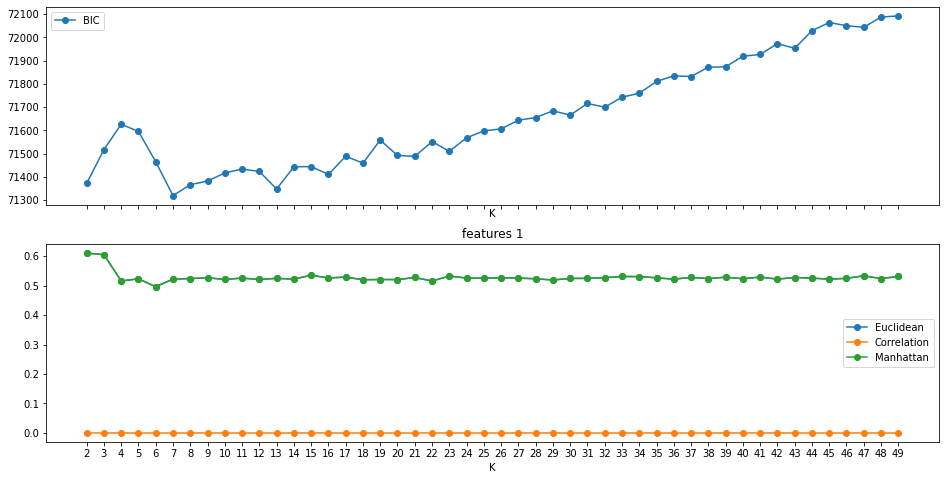

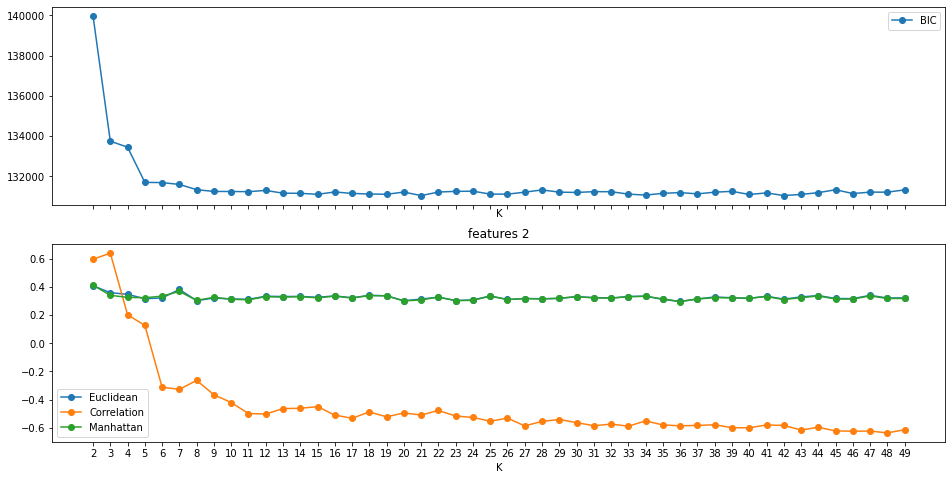

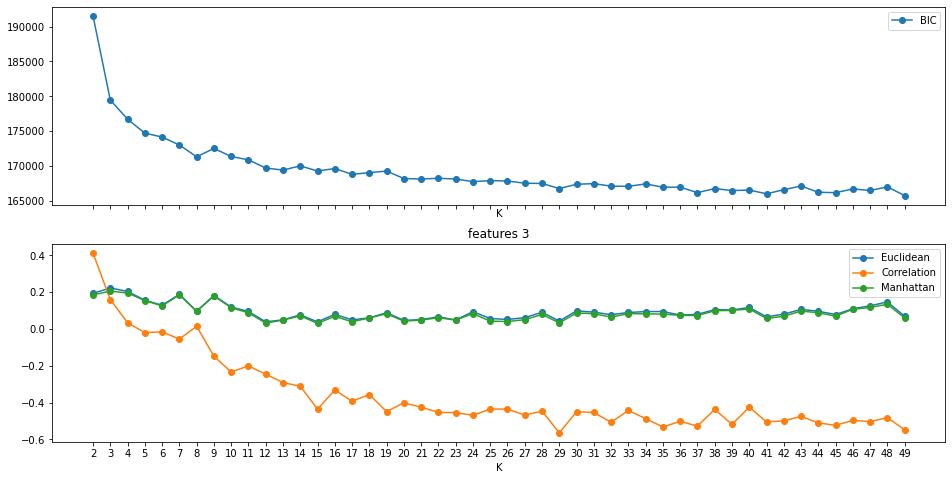

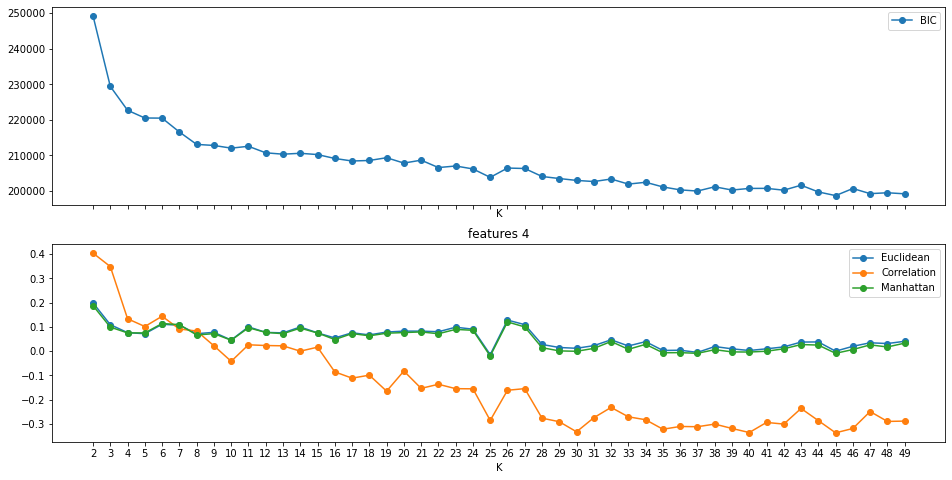

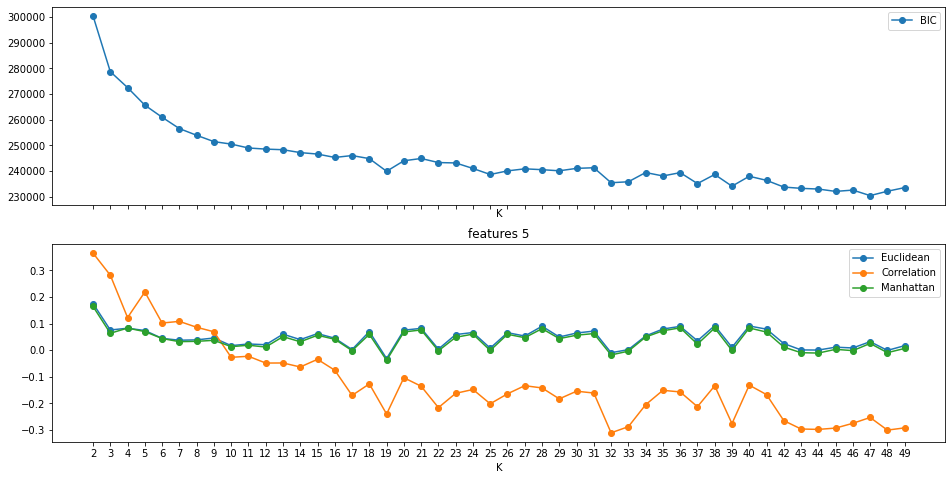

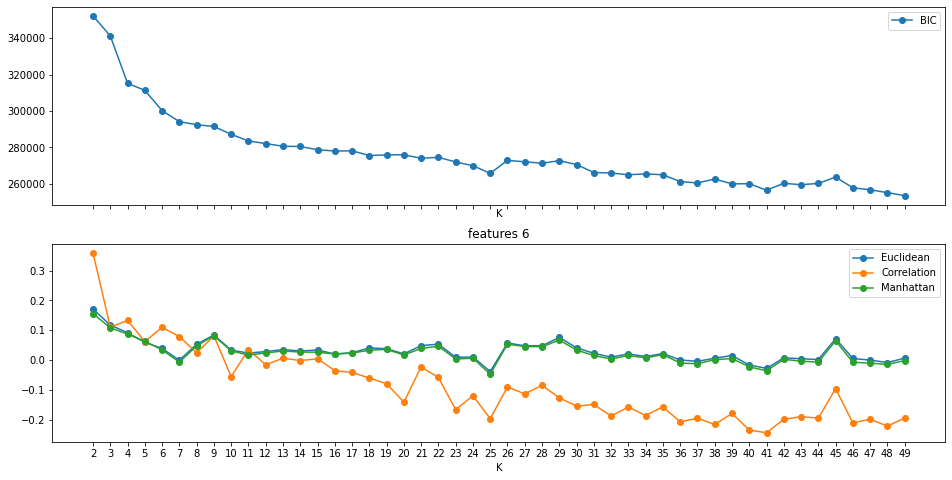

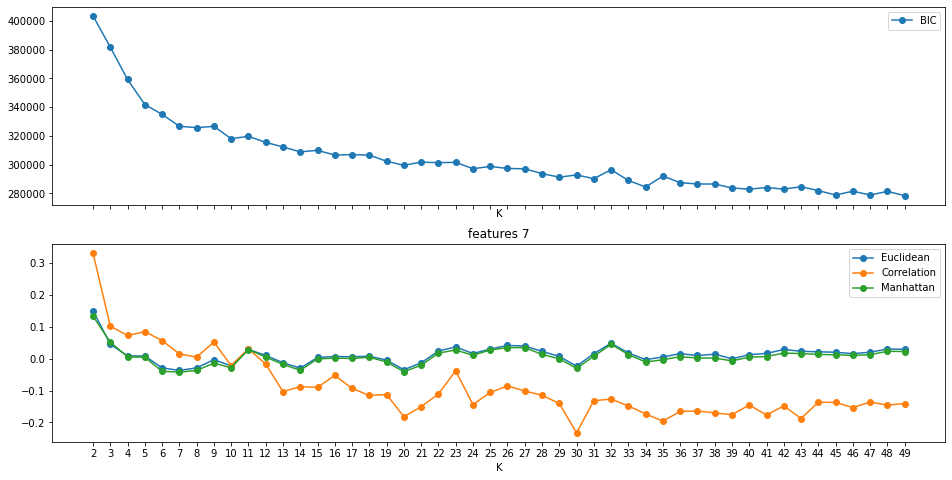

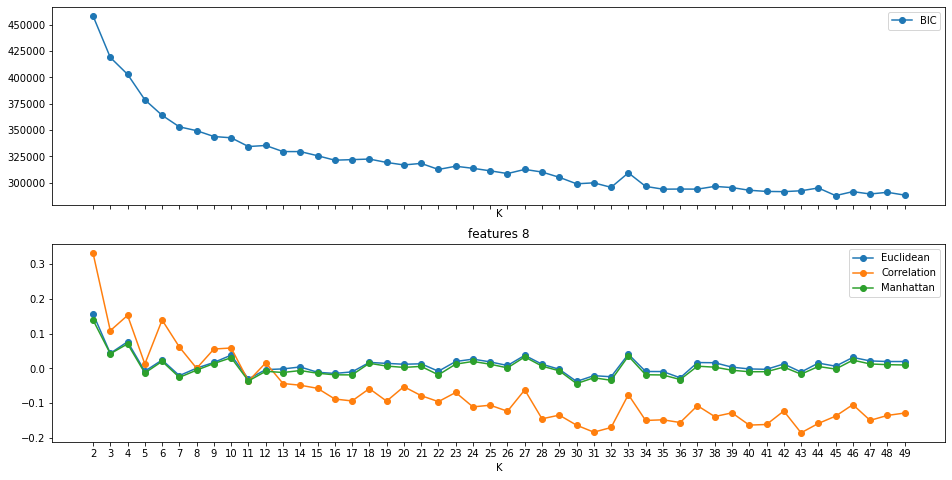

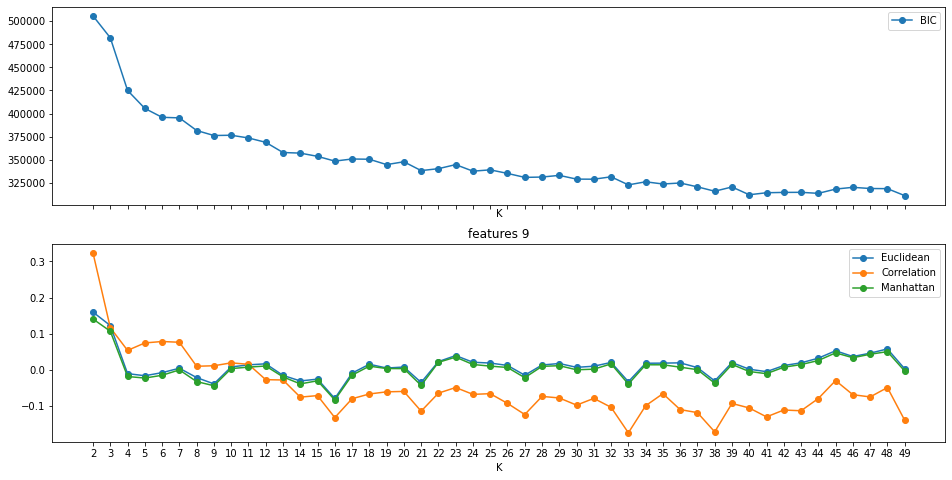

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.metrics import  silhouette_score

k_cand = list(np.arange(2,50,1))

results = dict()

for features in range(1,10):
    for k in k_cand:

        gmm = mixture.GaussianMixture(
            n_components=k, covariance_type='full'
        )
        labels = gmm.fit_predict(PCA_components.iloc[:,:features])
        score0 = gmm.bic(PCA_components.iloc[:,:features])
        score1 = silhouette_score(PCA_components.iloc[:,:features],labels,metric='euclidean')
        score2 = silhouette_score(PCA_components.iloc[:,:features],labels,metric='correlation')
        score3 = silhouette_score(PCA_components.iloc[:,:features],labels,metric='manhattan')
        results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2,'s3':score3}

    fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
    plt.title('features '+ str(features))
    axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='BIC')
    axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
    axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
    axs[1].plot([i for i in results.keys()],[i['s3'] for i in results.values()],'o-',label='Manhattan')
    for ax in axs:
        ax.set_xticks(k_cand)
        ax.set_xlabel('K')
        ax.legend()

    plt.show()

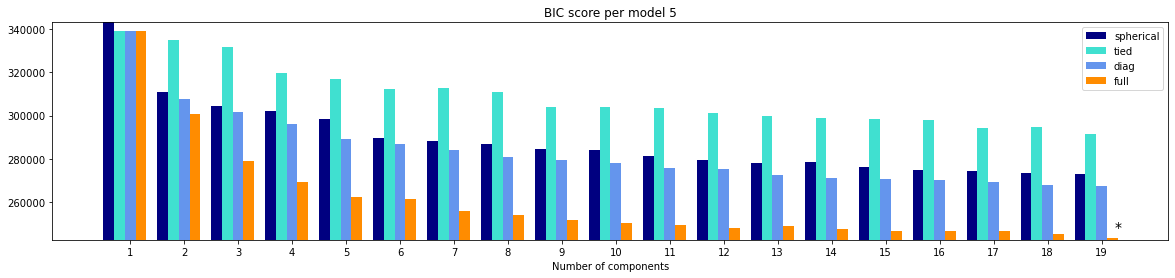

In [30]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn import mixture

features = 5
# for features in range(1,20):
lowest_bic = np.infty
bic = []
n_components_range = list(np.arange(1, 20,1))
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(PCA_components.iloc[:,:features])
        bic.append(gmm.bic(PCA_components.iloc[:,:features]))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(20, 4))
spl = plt.subplot(1, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model " +str(features))
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)
plt.show()

In [21]:
dataset.to_csv("Finalcluster_cheat.csv")

In [25]:
checkingMatrix = dataset.iloc[:,-10:]

In [26]:
checkingMatrix

,gmmLabels-1511,democ,autoc,polity,polity2,v2x_polyarchy,v2x_libdem,v2x_partipdem,v2x_delibdem,v2x_egaldem
0,0,0.0,1.0,0.0,0.0,0.081000,0.068000,0.028000,0.061000,0.066
1,0,0.6,0.1,1.5,1.5,0.482667,0.337667,0.310333,0.427667,0.367
2,9,1.0,0.0,2.0,2.0,0.824000,0.766000,0.582000,0.727000,0.666
3,14,1.0,0.0,2.0,2.0,0.836000,0.693000,0.592000,0.608000,0.725
4,0,NaN,NaN,NaN,NaN,0.108000,0.060000,0.066000,0.025000,0.052
...,...,...,...,...,...,...,...,...,...,...
14134,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14135,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14136,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14137,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import scipy.stats as scStat

setToCompare = "gmmLabels-84"
clusters = len(checkingMatrix[setToCompare].unique())
democracyScore = "v2x_libdem"

clusters = len(checkingMatrix[setToCompare].unique())

bars = [np.mean(checkingMatrix[checkingMatrix[setToCompare]==i][democracyScore].dropna().values) for i in range(clusters)]
plt.bar(range(clusters),bars)
plt.xticks(range(clusters))
plt.show()


# zeroArray = np.zeros((clusters+1,clusters+1))
zeroArray = [[0]*(clusters+1)]*(clusters+1)

barlett = [checkingMatrix[checkingMatrix[setToCompare]==i][democracyScore].dropna().values for i in range(clusters)]
barlettTest = scStat.levene(*barlett)

print(barlettTest)

for i in range(clusters):
    # print(len(checkingMatrix[checkingMatrix[setToCompare]==i]["v2x_partipdem"]))
    compareSet = checkingMatrix[checkingMatrix[setToCompare]==i][democracyScore].dropna().values
    if len(compareSet) > 8:
        normality_v2X_PartiDem = scStat.normaltest(compareSet)
        print(normality_v2X_PartiDem, barlettTest)
        for z in range(clusters):
            tTest = 0
            if i != z:
                compareSet2 = checkingMatrix[checkingMatrix[setToCompare]==z][democracyScore].dropna().values
                levene = scStat.levene(compareSet,compareSet2)
                print(levene)

                if len(compareSet2) > 8:
                    tTest = scStat.ttest_ind(compareSet,compareSet2)
                    zeroArray[i][z] = (tTest[1], levene[1])
                    print("Compare "+ democracyScore +", of cluster", i, " against:", z, ":", tTest)
                    print("")
            else:
                zeroArray[i][z] = 1
    print("")

zeroArray